# ‚Ññ17. –¢—Ä–∞–Ω—Å—Ñ–µ—Ä–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ (Transfer learning)

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets
import torchvision.models as models

from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö

### 1.1 –ó–∞–≥—Ä—É–∑–∫–∞ –∏ —Ä–∞—Å–ø–∞–∫–æ–≤–∫–∞ zip-–∞—Ä—Ö–∏–≤–∞ —Å –¥–∞–Ω–Ω—ã–º–∏

In [4]:
import requests
import os
import zipfile

DATA_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
DATA_PATH = os.path.join('.', 'data')
FILE_NAME = os.path.join(DATA_PATH, 'hymenoptera_data.zip')

if not os.path.isfile(FILE_NAME):
    print("Downloading the data...")
    os.makedirs('data', exist_ok=True)
    with requests.get(DATA_URL) as req:
        with open(FILE_NAME, 'wb') as f:
            f.write(req.content)
    if 200 <= req.status_code < 300:
        print("Download complete!")
    else:
        print("Download failed!")
else:
    print(FILE_NAME, "already exists, skipping download...")

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
    print("Unzipping...")
    zip_ref.extractall('data')

DATA_PATH = os.path.join(DATA_PATH, 'hymenoptera_data')
print("", DATA_PATH)

.\data\hymenoptera_data.zip already exists, skipping download...
Unzipping...
 .\data\hymenoptera_data


### 1.2 –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [5]:
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_data = datasets.ImageFolder("./data/hymenoptera_data/train", transform=transforms_train)
val_data = datasets.ImageFolder("./data/hymenoptera_data/val", transform=transforms_val)
len(train_data), len(val_data)

(244, 153)

In [7]:
class_names = train_data.classes
class_names

['ants', 'bees']

In [8]:
BATCH_SIZE = 16
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

## 2. –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π

In [79]:
import numpy as np
import random
import matplotlib.pyplot as plt

### 2.0 –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏

In [ ]:
def plot_training_curves(train_loss, val_loss, train_acc, val_acc, lr_list):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(train_loss, label="Train Loss")
    axes[0].plot(val_loss, label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss Curve")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_acc, label="Train Accuracy")
    axes[1].plot(val_acc, label="Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy Curve")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(lr_list, label="LR Rate")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Learning Rate")
    axes[2].set_title("Learning Rate Curve")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [48]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    opt: torch.optim.Optimizer,
    loss_model: nn.Module,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler
    ):
    
    EPOCHS = n_epochs
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    lr_list = []

    # –¶–∏–∫–ª –æ–±—É—á–µ–Ω–∏—è
    for epoch in range(EPOCHS):
        
        # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
        model.train()
        running_train_loss = []
        true_answer = 0
        train_loop = tqdm(train_loader, leave=False)
        
        for x, targets in train_loop:
            # –û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(2)[targets].to(device)
            
            # –ü—Ä—è–º–æ–π –ø—Ä–æ—Ö–æ–¥ –∏ —Ä–∞—Å—á–µ—Ç –æ—à–∏–±–∫–∏ –º–æ–¥–µ–ª–∏
            pred = model(x)
            loss = loss_model(pred, targets)
            
            # –û–±—Ä–∞—Ç–Ω—ã–π –ø—Ä–æ—Ö–æ–¥
            opt.zero_grad() # –æ–±–Ω—É–ª—è–µ–º –ø—Ä–µ–¥—ã–¥—É—â–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã
            loss.backward() # –≤—ã—á–∏—Å—è–ª–µ–º –Ω–æ–≤—ã–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã
            opt.step()      # –ø—Ä–∏–º–µ–Ω—è–µ–º —à–∞–≥ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)
            
            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
            
            desc = f"Epoch [{epoch+1}/{EPOCHS}], {mean_train_loss=:.4f}"
            train_loop.set_description(desc)
            
        # –†–∞—Å—á–µ—Ç –∑–Ω–∞—á–µ–Ω–∏—è —Ç–æ—á–Ω–æ—Å—Ç–∏ –ø–æ—Å–ª–µ —ç–ø–æ—Ö–∏ –æ–±—É—á–µ–Ω–∏—è
        running_train_acc = true_answer / len(train_data)
        
        # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –∏ —Ç–æ—á–Ω–æ—Å—Ç–∏
        train_loss.append(mean_train_loss)
        train_acc.append(running_train_acc)
        
        # –í–∞–ª–∏–¥–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
        model.eval()
        with torch.no_grad():
            running_val_loss = []
            true_answer = 0
            for x, targets in val_loader:
                # –û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö
                targets = targets.reshape(-1).to(torch.int32)
                targets = torch.eye(2)[targets].to(device)
                
                # –ü—Ä—è–º–æ–π –ø—Ä–æ—Ö–æ–¥ –∏ —Ä–∞—Å—á–µ—Ç –æ—à–∏–±–∫–∏ –º–æ–¥–µ–ª–∏
                pred = model(x)
                loss = loss_model(pred, targets)
        
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        # –†–∞—Å—á–µ—Ç —Ç–æ—á–Ω–æ—Å—Ç–∏    
        running_val_acc = true_answer / len(val_data)
        
        # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –∏ —Ç–æ—á–Ω–æ—Å—Ç–∏
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()[0]
        lr_list.append(lr)
        
        info = "Epoch [{}/{}], train_loss={:.4f}, train_acc={:.4f}, val_loss={:.4f}, val_acc={:4f}, lr={}" \
        .format(epoch+1, EPOCHS, mean_train_loss, running_train_acc, mean_val_loss, running_val_acc, lr)
        
        print(info)
        
    plot_training_curves(
        train_loss=train_loss,
        val_loss=val_loss,
        train_acc=train_acc,
        val_acc=val_acc,
        lr_list=lr_list
    )

### 2.1 –û–±—É—á–µ–Ω–∏–µ —Å –Ω—É–ª—è (–±–µ–∑ Transfer Learning)

#### –í–∞—Ä–∏–∞–Ω—Ç 1
- –ú–æ–¥–µ–ª—å –ù–ï –æ–±—É—á–µ–Ω–∞
- –ú–µ–Ω—è–µ–º —Ç–æ–ª—å–∫–æ –ø–æ—Å–ª–¥–µ–Ω–∏–π —Å–ª–æ–π —É VGG

In [49]:
model = models.vgg11()
model;

In [50]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [52]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [53]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

Epoch [1/5], train_loss=0.7525, train_acc=0.5082, val_loss=0.6774, val_acc=0.542484, lr=0.0001


Epoch [2/5], train_loss=0.6866, train_acc=0.5123, val_loss=0.6939, val_acc=0.509804, lr=0.0001


Epoch [3/5], train_loss=0.6346, train_acc=0.5861, val_loss=0.8935, val_acc=0.542484, lr=0.0001


Epoch [4/5], train_loss=0.6833, train_acc=0.6107, val_loss=0.6751, val_acc=0.594771, lr=0.0001


Epoch [5/5], train_loss=0.6435, train_acc=0.5656, val_loss=0.6718, val_acc=0.568627, lr=0.0001


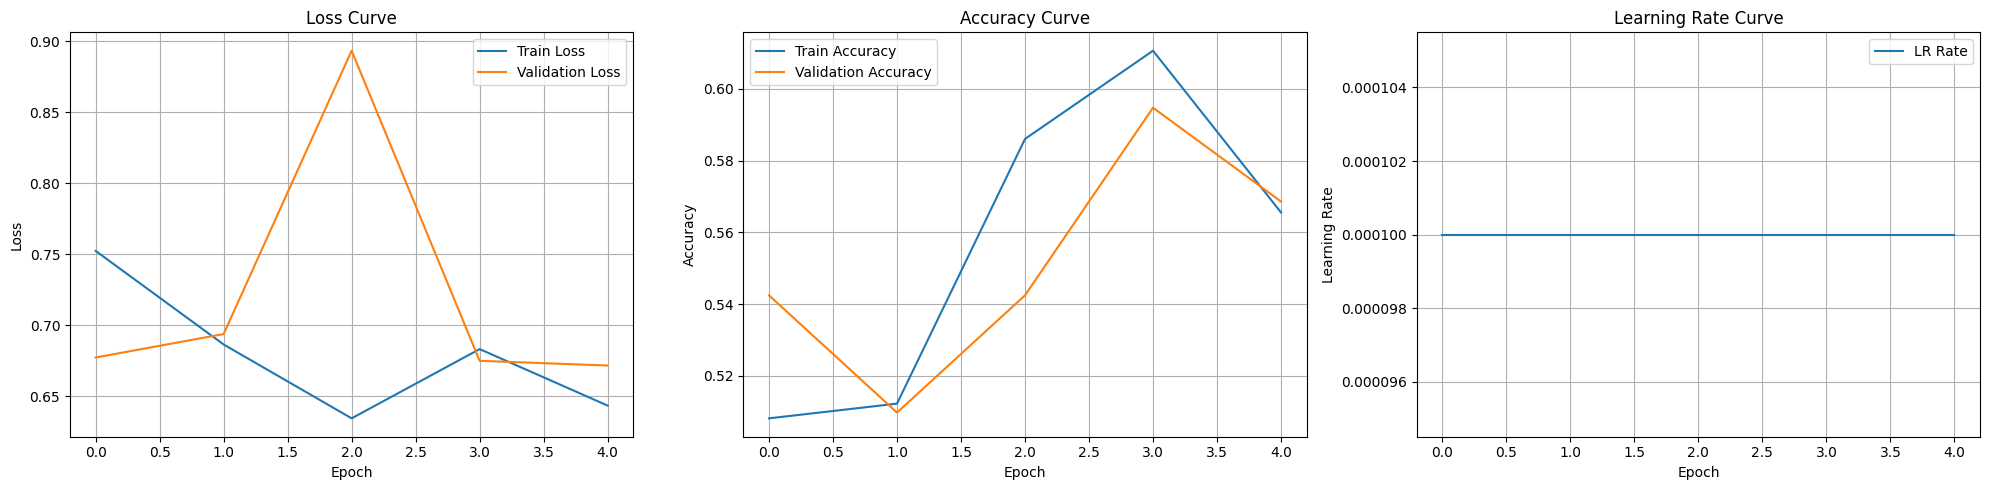

In [54]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**–í—ã–≤–æ–¥—ã:**
1. –ü–æ —Ñ–∞–∫—Ç—É –º–æ–¥–µ–ª—å –Ω–µ –æ–±—É—á–∏–ª–∞—Å—å
2. –û—á–µ–Ω—å –±–æ–ª—å—à–æ–µ –≤–ª–∏—è–Ω–∏–µ –∏–º–µ–µ—Ç `lr`
3. –û–±—É—á–µ–Ω–∏–µ –∑–∞–Ω–∏–º–∞–µ—Ç –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ (5 —ç–ø–æ—Ö –∑–∞ ~8 –º–∏–Ω 30 —Å–µ–∫)

–û–±—É—á–∞—Ç—å —Å –Ω—É–ª—è –≤ –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ - –ø–ª–æ—Ö–∞—è –∏–¥–µ—è.

#### –í–∞—Ä–∏–∞–Ω—Ç 2
- –ú–æ–¥–µ–ª—å –ù–ï –æ–±—É—á–µ–Ω–∞
- –ú–µ–Ω—è–µ–º –≤–µ—Å—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä

In [55]:
model = models.vgg11()
model.classifier = nn.Linear(512*7*7, 2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [56]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

Epoch [1/5], train_loss=1.5635, train_acc=0.4959, val_loss=0.6792, val_acc=0.542484, lr=0.001


Epoch [2/5], train_loss=0.7035, train_acc=0.5328, val_loss=0.6999, val_acc=0.457516, lr=0.001


Epoch [3/5], train_loss=0.6944, train_acc=0.5041, val_loss=0.6973, val_acc=0.457516, lr=0.001


Epoch [4/5], train_loss=0.6946, train_acc=0.5041, val_loss=0.6958, val_acc=0.457516, lr=0.0001


Epoch [5/5], train_loss=0.6932, train_acc=0.5041, val_loss=0.6951, val_acc=0.457516, lr=0.0001


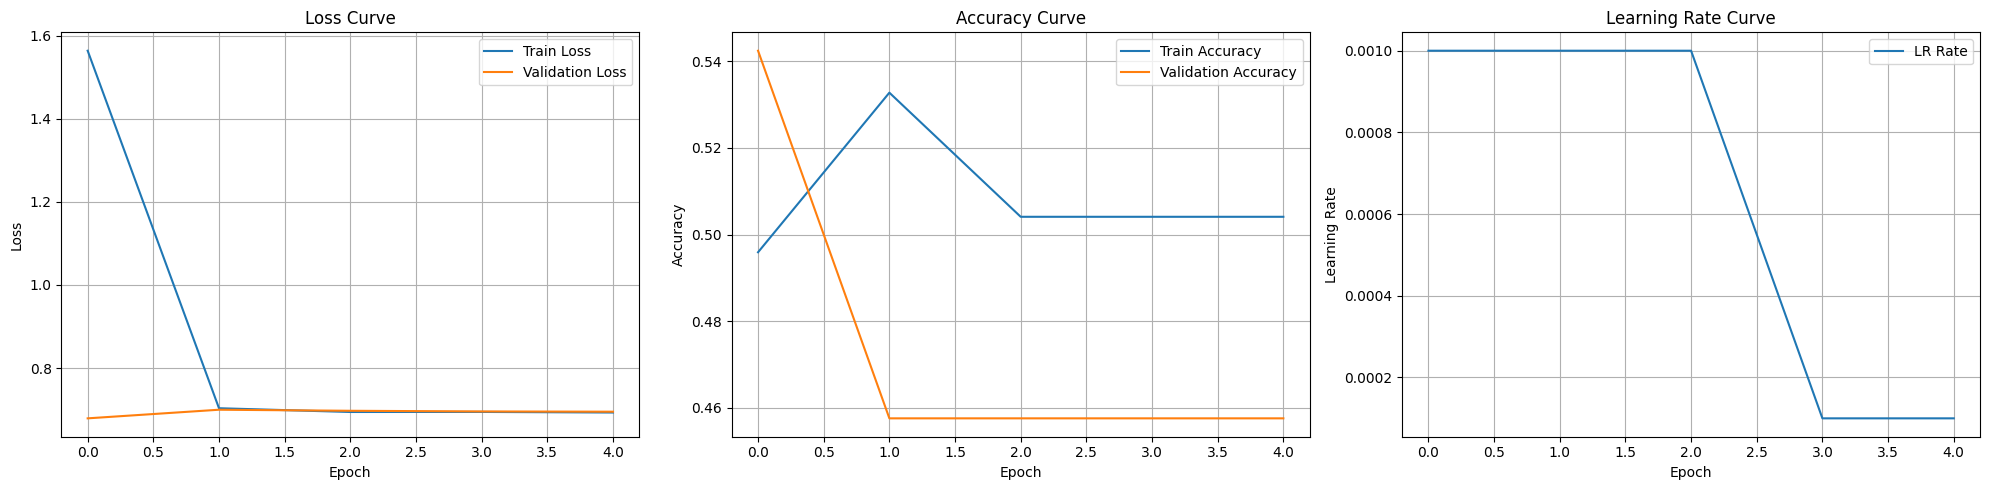

In [57]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**–í—ã–≤–æ–¥—ã:**
1. –ü–æ —Ñ–∞–∫—Ç—É –º–æ–¥–µ–ª—å –Ω–µ –æ–±—É—á–∏–ª–∞—Å—å
2. –û—á–µ–Ω—å –±–æ–ª—å—à–æ–µ –≤–ª–∏—è–Ω–∏–µ –∏–º–µ–µ—Ç `lr`

–í—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è —Å–Ω–∏–∑–∏–ª–æ—Å—å –ø–æ –ø—Ä–∏—á–∏–Ω–µ –∑–∞–º–µ–Ω—ã —Å–ª–æ—è –∫–ª–∞—Å—Å–∏—Ñ–∫–∞—Ç–æ—Ä–∞, –∫–æ—Ç–æ—Ä—ã–π –∏–º–µ–µ—Ç –º–µ–Ω—å—à–µ –≤–µ—Å–æ–≤, –æ–¥–Ω–∞–∫–æ —Ç–æ—á–Ω–æ—Å—Ç—å –≤—Å–µ —Ç–∞–∫–∂–µ –æ—Å—Ç–∞–≤–ª—è–µ—Ç –∂–µ–ª–∞—Ç—å –ª—É—á—à–µ–≥–æ.

### 2.2 –û–±—É—á–µ–Ω–∏–µ —Å Transfer Learning

#### –í–∞—Ä–∏–∞–Ω—Ç 1
- –ú–æ–¥–µ–ª—å –æ–±—É—á–µ–Ω–∞
- –ù–ï –∑–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –æ–±—É—á–µ–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
- –ú–µ–Ω—è–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–π —Å–ª–æ–π

In [60]:
model = models.vgg11(weights='DEFAULT')
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [61]:
model.classifier[6] = nn.Linear(4096, 2)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [62]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

Epoch [1/5], train_loss=1.5550, train_acc=0.5000, val_loss=0.8242, val_acc=0.542484, lr=0.001


Epoch [2/5], train_loss=0.7856, train_acc=0.4385, val_loss=0.6719, val_acc=0.542484, lr=0.001


Epoch [3/5], train_loss=0.7027, train_acc=0.4959, val_loss=0.6758, val_acc=0.535948, lr=0.001


Epoch [4/5], train_loss=0.7052, train_acc=0.5287, val_loss=0.6593, val_acc=0.535948, lr=0.001


Epoch [5/5], train_loss=0.7107, train_acc=0.4795, val_loss=0.6617, val_acc=0.549020, lr=0.001


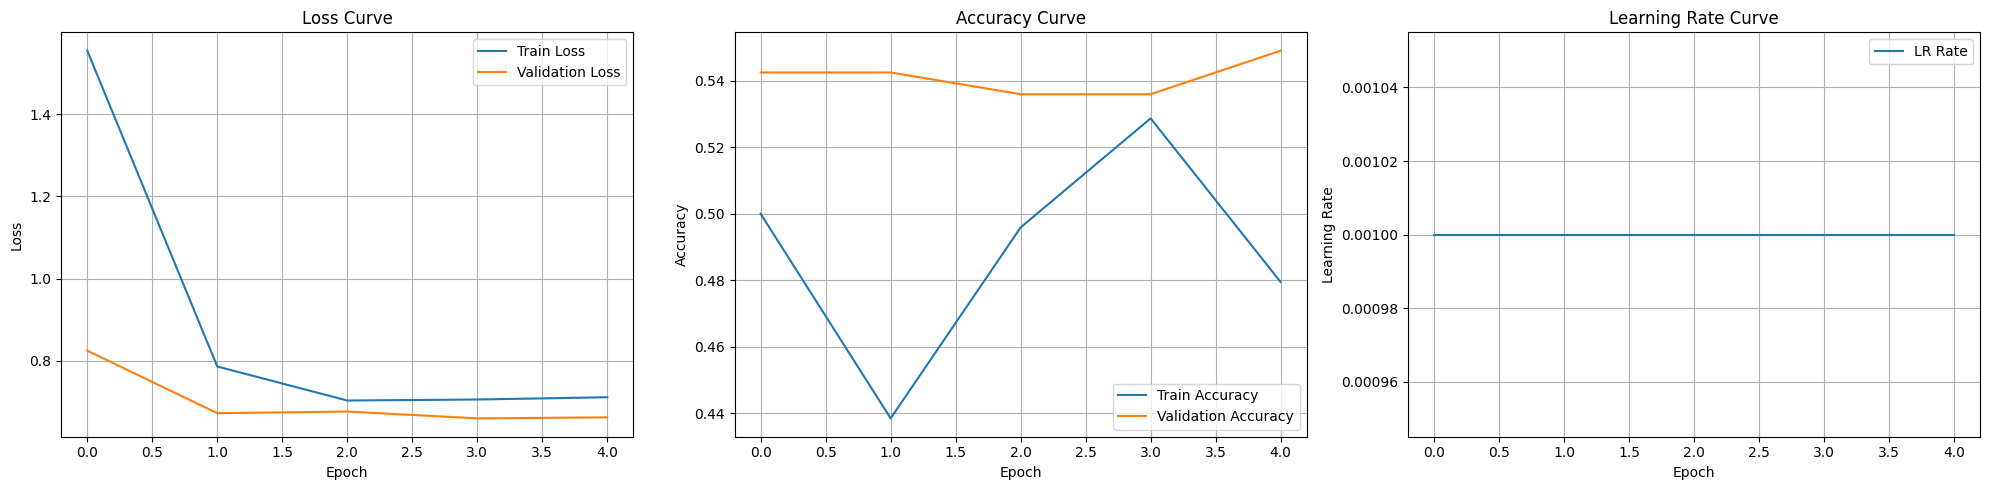

In [63]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**–í—ã–≤–æ–¥—ã:**
1. –ü–æ —Ñ–∞–∫—Ç—É –º–æ–¥–µ–ª—å –Ω–µ –æ–±—É—á–∏–ª–∞—Å—å
2. –û–±—É—á–µ–Ω–∏–µ –∑–∞–Ω–∏–º–∞–µ—Ç –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏ (5 —ç–ø–æ—Ö –∑–∞ ~10 –º–∏–Ω 50 c–µ–∫)

–ò–∑-–∑–∞ –Ω–µ–æ–±—É—á–µ–Ω–Ω–æ—Å—Ç–∏ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ —Å–ª–æ—è, –ø–æ–ª—É—á–∏–ª–∏ –ø–æ –∏—Ç–æ–≥–∞–º –ø–µ—Ä–≤–æ–π —ç–ø–æ—Ö–∏ –±–æ–ª—å—à–∏–µ —à–∞–≥–∏ –≥—Ä–∞–¥–∏–Ω–µ—Ç–∞, —Å–ª–µ–¥—Å—Ç–≤–∏–µ–º —ç—Ç–æ–≥–æ —è–≤–ª—è–µ—Ç—Å—è –ø—Ä–æ—Å–∞–¥–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ –Ω–∞ 2 —ç–ø–æ—Ö–µ. –°–Ω–æ–≤–∞ –º–æ–¥–µ–ª—å –Ω–µ –æ–±—É—á–∏–ª–∞—Å—å, –≤—Ä–µ–º–µ–Ω–∏ –Ω–∞ –æ–±—É—á–µ–Ω–∏–µ –∑–∞—Ç—Ä–∞—Ç–∏–ª–∏ –∫—É—á—É. –ü–æ —Å—É—Ç–∏ —Ç–æ–ª—å–∫–æ —Å–±–∏–ª–∏ –æ–±—É—á–µ–Ω–Ω—ã–µ –≤–µ—Å–∞, —Ç–∞–∫ –µ—â–µ –∏ –Ω–µ –æ–±—É—á–∏–ª–∏ –≤—Å–µ —Ä–∞–≤–Ω–æ –º–æ–¥–µ–ª—å.    

#### –í–∞—Ä–∏–∞–Ω—Ç 2
- –ú–æ–¥–µ–ª—å –æ–±—É—á–µ–Ω–∞
- –ù–ï –∑–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –æ–±—É—á–µ–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
- –ú–µ–Ω—è–µ–º –≤–µ—Å—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä

In [64]:
model = models.vgg11(weights='DEFAULT')
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [65]:
model.classifier = nn.Linear(512*7*7, 2)
model.classifier

Linear(in_features=25088, out_features=2, bias=True)

In [66]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/5], train_loss=2.2852, train_acc=0.5656, val_loss=4.0984, val_acc=0.457516, lr=0.001


Epoch [2/5], train_loss=0.9801, train_acc=0.5533, val_loss=0.6586, val_acc=0.549020, lr=0.001


Epoch [3/5], train_loss=0.6938, train_acc=0.5492, val_loss=0.6155, val_acc=0.699346, lr=0.001


Epoch [4/5], train_loss=0.6109, train_acc=0.6762, val_loss=0.5707, val_acc=0.718954, lr=0.001


Epoch [5/5], train_loss=0.5941, train_acc=0.6885, val_loss=0.5813, val_acc=0.673203, lr=0.001


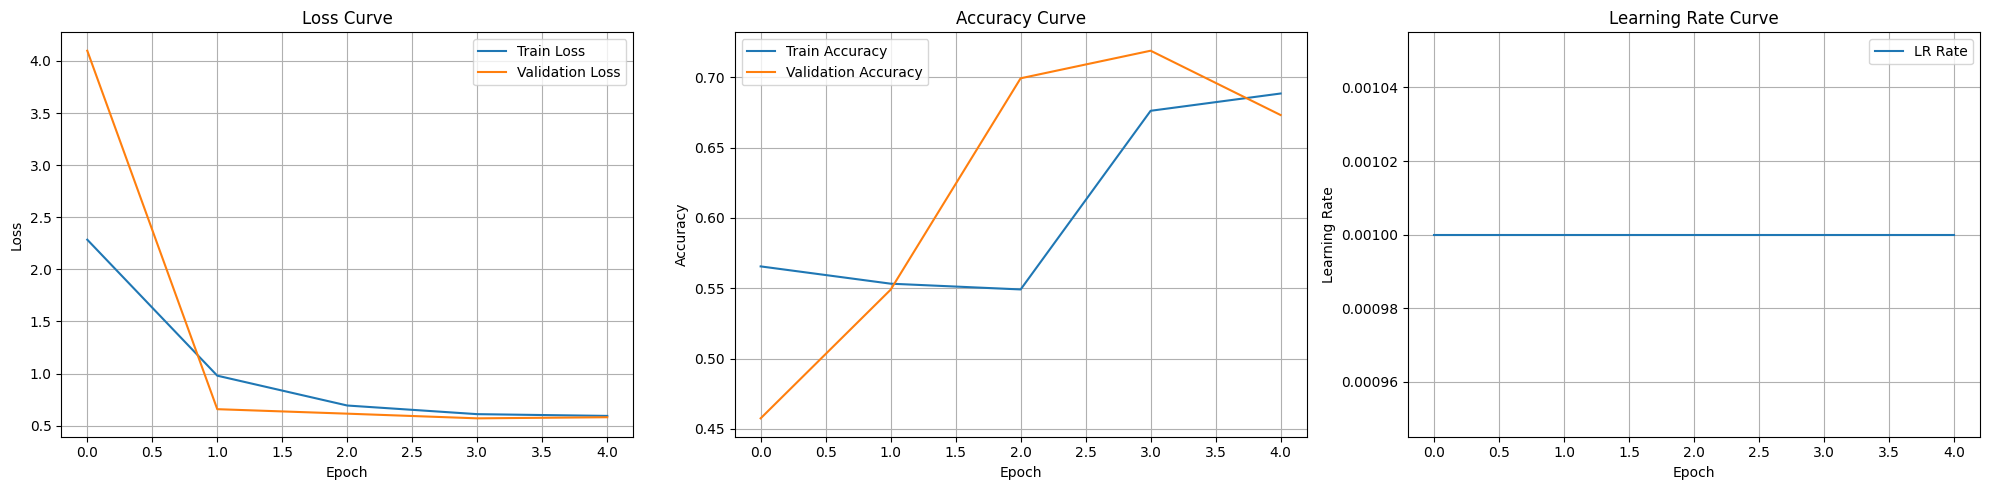

In [67]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

–ù–∞–±–ª—é–¥–∞–µ–º —Å—Ç–∞–±–ª–∏—å–Ω–æ–µ —Å–Ω–∏–∂–µ–Ω–∏–µ ***loss*** –∏ –ø–æ–≤—ã—à–µ–Ω–∏–µ ***accuracy***, –ø—Ä–æ–≥–æ–Ω–∏–º –º–æ–¥–µ–ª—å –µ—â–µ —á–µ—Ä–µ–∑ 5 —ç–ø–æ—Ö.

Epoch [1/5], train_loss=0.5505, train_acc=0.7541, val_loss=0.5539, val_acc=0.745098, lr=0.001


Epoch [2/5], train_loss=0.5775, train_acc=0.6803, val_loss=0.7270, val_acc=0.758170, lr=0.001


Epoch [3/5], train_loss=0.5421, train_acc=0.7213, val_loss=0.7368, val_acc=0.594771, lr=0.001


Epoch [4/5], train_loss=0.5362, train_acc=0.7459, val_loss=0.6410, val_acc=0.633987, lr=0.0001


Epoch [5/5], train_loss=0.5728, train_acc=0.6762, val_loss=0.5889, val_acc=0.647059, lr=0.0001


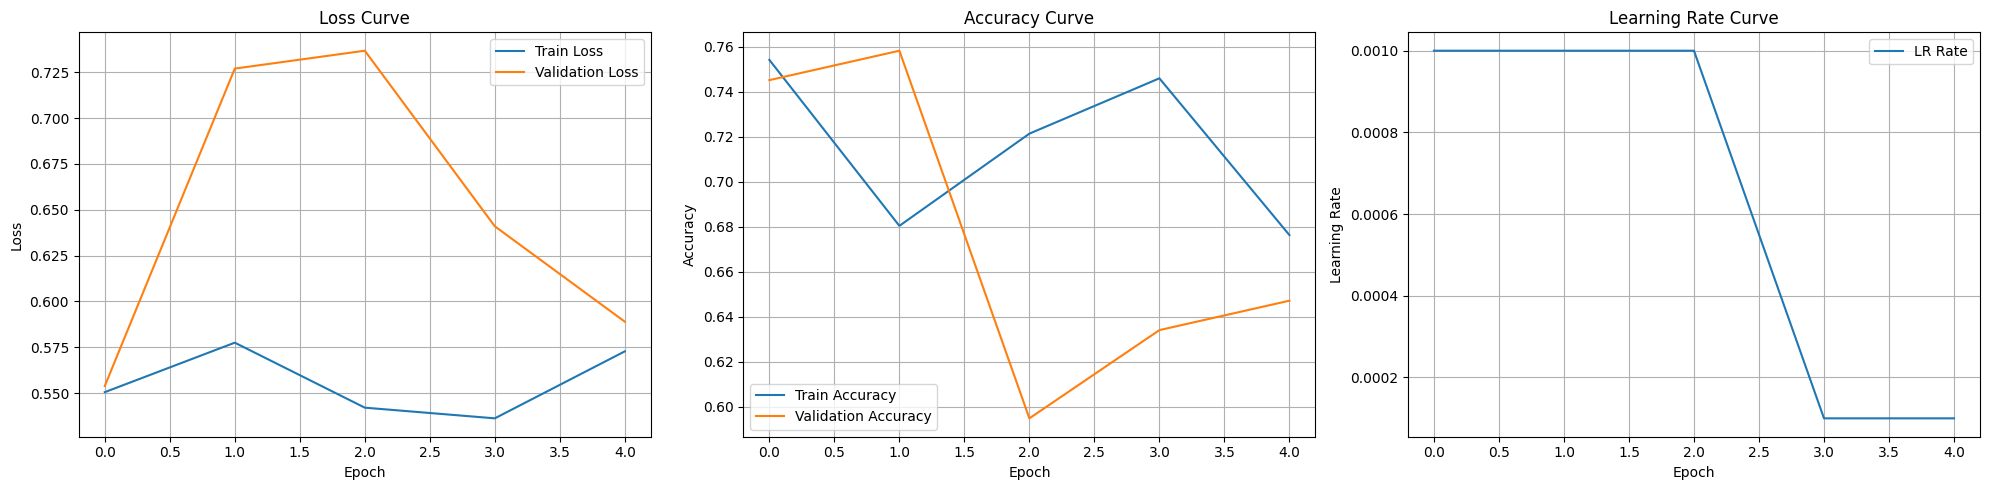

In [75]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**–í—ã–≤–æ–¥—ã:**
1. –î–æ—Å–∏–≥–ª–∏ —Ä–µ–∫–æ—Ä–¥–Ω–æ–≥–æ accuracy score –≤ ~75% –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ
2. –û–±—É—á–µ–Ω–∏–µ –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –±—ã—Å—Ç—Ä–æ–µ (5 —ç–ø–æ—Ö –∑–∞ ~5 –º–∏–Ω 40 c–µ–∫)

–î–∞–Ω–Ω—ã–π –ø–æ–¥—Ö–æ–¥ –∏–º–µ–µ—Ç –º–µ—Å—Ç–æ –±—ã—Ç—å, –Ω–æ —Ç—Ä–µ–±—É–µ—Ç —Ç–æ–Ω–∫–æ–π –Ω–∞—Å—Ç—Ä–æ–π–∫–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, —á—Ç–æ–±—ã –Ω–µ –ø–µ—Ä–µ–æ–±—É—á–∏—Ç—å –º–æ–¥–µ–ª—å, –∫–∞–∫ –≤ –Ω–∞—à–µ–º —Å–ª—É—á–∞–µ.

#### –í–∞—Ä–∏–∞–Ω—Ç 3 üëë
- –ú–æ–¥–µ–ª—å –æ–±—É—á–µ–Ω–∞
- **–ó–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –æ–±—É—á–µ–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã**
- –ú–µ–Ω—è–µ–º –≤–µ—Å—å –∫–ª–∞—Å—Å—Ñ–∏–∫–∞—Ç–æ—Ä

In [76]:
model = models.vgg11(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False # –æ—Ç–∫–ª—é—á–∞–µ–º –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ –¥–ª—è —Ç–µ–Ω–∑–æ—Ä–æ–≤-–≤–µ—Å–æ–≤
    
model.classifier = nn.Linear(512*7*7, 2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [77]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

Epoch [1/15], train_loss=0.4753, train_acc=0.8402, val_loss=0.6943, val_acc=0.895425, lr=0.001


Epoch [2/15], train_loss=0.2950, train_acc=0.9385, val_loss=0.6607, val_acc=0.915033, lr=0.001


Epoch [3/15], train_loss=0.1516, train_acc=0.9508, val_loss=0.8021, val_acc=0.921569, lr=0.001


Epoch [4/15], train_loss=0.1903, train_acc=0.9631, val_loss=0.6486, val_acc=0.915033, lr=0.001


Epoch [5/15], train_loss=0.0285, train_acc=0.9836, val_loss=0.6380, val_acc=0.928105, lr=0.001


Epoch [6/15], train_loss=0.0355, train_acc=0.9877, val_loss=0.6253, val_acc=0.915033, lr=0.001


Epoch [7/15], train_loss=0.0159, train_acc=0.9918, val_loss=0.8268, val_acc=0.921569, lr=0.001


Epoch [8/15], train_loss=0.1082, train_acc=0.9795, val_loss=0.7379, val_acc=0.928105, lr=0.001


Epoch [9/15], train_loss=0.0038, train_acc=1.0000, val_loss=0.7533, val_acc=0.928105, lr=0.001


Epoch [10/15], train_loss=0.0159, train_acc=0.9959, val_loss=0.7817, val_acc=0.934641, lr=0.001


Epoch [11/15], train_loss=0.0042, train_acc=1.0000, val_loss=0.7693, val_acc=0.928105, lr=0.001


Epoch [12/15], train_loss=0.0032, train_acc=1.0000, val_loss=0.7903, val_acc=0.928105, lr=0.0001


Epoch [13/15], train_loss=0.0022, train_acc=1.0000, val_loss=0.7874, val_acc=0.928105, lr=0.0001


Epoch [14/15], train_loss=0.0244, train_acc=0.9918, val_loss=0.7843, val_acc=0.928105, lr=0.0001


Epoch [15/15], train_loss=0.0029, train_acc=1.0000, val_loss=0.7794, val_acc=0.928105, lr=0.0001


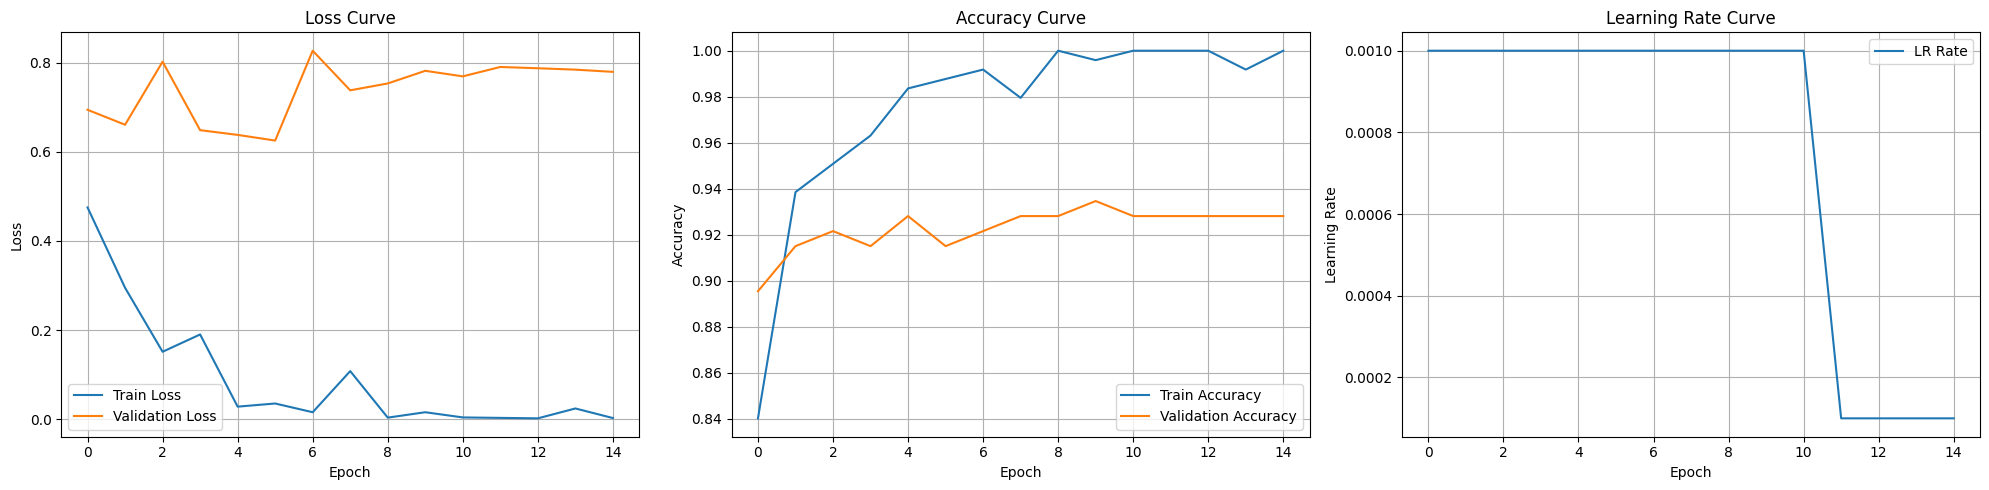

In [78]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=15,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

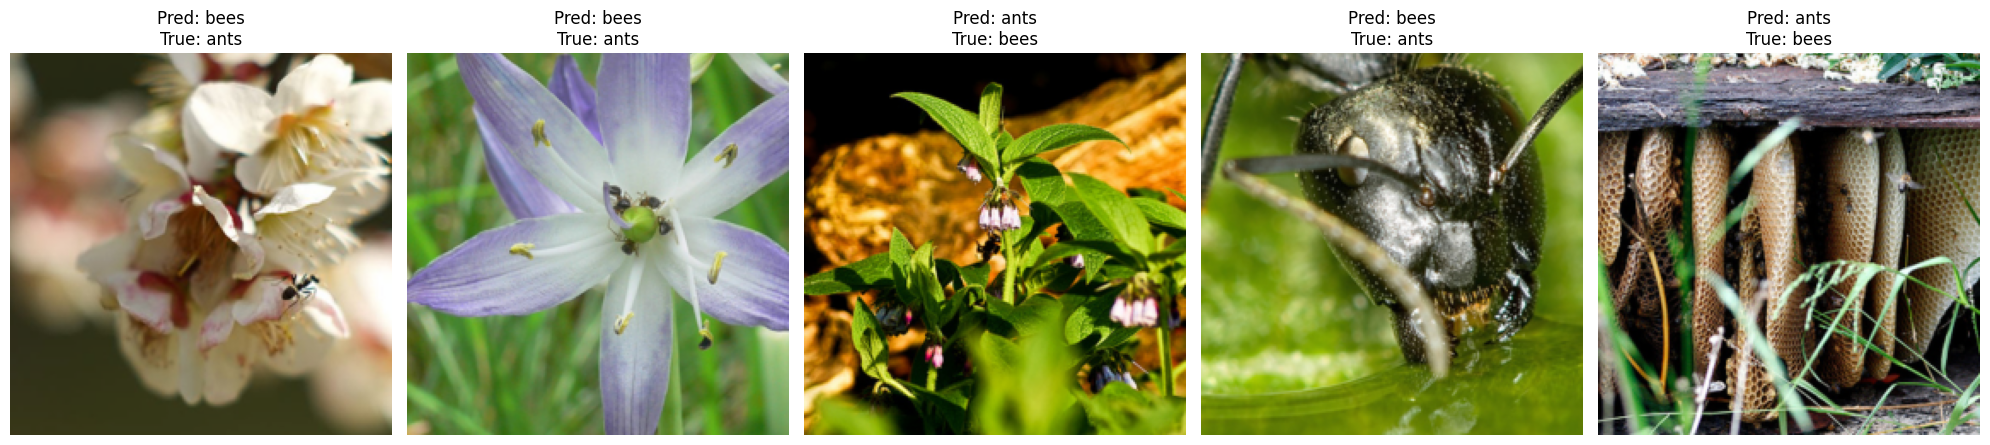

In [ ]:
# –ü–µ—Ä–µ–≤–µ–¥—ë–º –º–æ–¥–µ–ª—å –≤ —Ä–µ–∂–∏–º –æ—Ü–µ–Ω–∫–∏
model.eval()

errors = []
images_shown = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # –ù–∞–∫–∞–ø–ª–∏–≤–∞–µ–º –æ—à–∏–±–∫–∏
        for img, pred, label in zip(inputs.cpu(), preds.cpu(), labels.cpu()):
            if pred != label:
                errors.append((img, pred.item(), label.item()))
        if len(errors) > 100:  # –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –Ω–∞—Å–æ–±–∏—Ä–∞—Ç—å 100 –æ—à–∏–±–æ–∫, —á—Ç–æ–±—ã –¥–ª—è rnd –≤—ã–±—Ä–∞—Ç—å 5, –ø–æ—Ç–æ–º –≤—ã–π–¥–µ–º
            break

# –°–ª—É—á–∞–π–Ω–æ –≤—ã–±–∏—Ä–∞–µ–º 5 –æ—à–∏–±–æ—á–Ω—ã—Ö
to_show = random.sample(errors, min(5, len(errors)))

plt.figure(figsize=(20, 5))
for i, (img, pred, label) in enumerate(to_show):
    plt.subplot(1, 5, i+1)
    # denormalize, –µ—Å–ª–∏ –ø—Ä–∏–º–µ–Ω—è–ª—Å—è normalization –≤ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ
    img = img.permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**–í—ã–≤–æ–¥—ã**:

–ö–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –∏–∑–ª–∏—à–Ω–∏, —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –Ω–∞ –≤–∞—à–∏—Ö —ç–∫—Ä–∞–Ω–∞—Ö, –≥–æ—Å–ø–æ–¥–∞.
1. 15 —ç–ø–æ—Ö –æ–±—É—á–µ–Ω–∏—è –∑–∞ **8 –º–∏–Ω—É—Ç**
2. **92% —Ç–æ—á–Ω–æ—Å—Ç–∏** –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ (–ø–µ—Ä–µ–≥—Ä–µ–ª–∏ –º–æ–¥–µ–ª—å–∫—É, –Ω–∞ –≥—Ä–∞—Ñ–∏–∫–µ —á–µ—Ç–∫–æ –≤–∏–¥–Ω–æ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ - –Ω–µ–æ–±—Ö–æ–¥–∏–º –±–æ–ª–µ–µ —É–º–Ω—ã–π *lr_scheduler*)

***Transfer Learning*** - –æ—Ç–ª–∏—á–Ω—ã–π –ø–æ–¥—Ö–æ–¥, –∫–æ—Ç–æ—Ä—ã–π –ø–æ–º–æ–≥–∞–µ—Ç –∑–∞ –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –≤—Ä–µ–º—è –∏ —Ä–µ—Å—É—Ä—Å—ã –ø–æ–ª—É—á–∏—Ç—å —Ö–æ—Ä–æ—à–∏–µ –ø–æ–∫–∞–∑–∞—Ç–µ–ª–∏ —Ç–æ—á–Ω–æ—Å—Ç–∏.